<a href="https://colab.research.google.com/github/iamhb/BITS_Final_SEM/blob/main/Final_Project_Execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install & Imports

In [ ]:
!pip install -q psycopg2-binary sqlalchemy
!pip install -q langchain langchain-community chromadb
!pip install -q sentence-transformers
!pip install -q transformers accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import psycopg2

Device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

DB connection

In [ ]:
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

DB_USER = "postgres.hxwwrvlxbvrmhbvdvmbd"
DB_PASSWORD = "B!T$@F!n4L_Pr0J3cT#"
DB_HOST = "aws-1-ap-southeast-2.pooler.supabase.com"
DB_PORT = "6543"
DB_NAME = "postgres"

DB_PASSWORD_ENCODED = quote_plus(DB_PASSWORD)

DATABASE_URL = (
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD_ENCODED}"
    f"@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

engine = create_engine(
    DATABASE_URL,
    pool_pre_ping=True,
    pool_size=5,
    max_overflow=5,
)


Testing DB connection

In [ ]:
with engine.connect() as conn:
    print(conn.execute(text("SELECT 1")).all())

[(1,)]


Execute SQL

In [ ]:
def execute_sql(sql):
    try:
        with engine.connect() as conn:
            result = conn.execute(text(sql))
            rows = result.fetchall()
            return rows, True
    except Exception as e:
        print(f"SQL Error: {e}")
        return str(e), False

Model name

In [ ]:
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.3"

Test Questionss

In [ ]:
questions = [
    "Show all customers",
    "Count number of orders",
    "List orders placed in 2024",
    "Show total sales per customer",
    "Find customers with no orders"
]

======================================================Experiment A======================================================
==========================================Baseline model - Non Quantized, No Schema ====================================

Load Baseline Model

In [ ]:
tokenizer_base = AutoTokenizer.from_pretrained(MODEL_NAME)
model_base = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto",
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Bseline Prompt Builder

In [ ]:
def build_baseline_prompt(question):
    return f"""
        Translate the following question into SQL.

        Question: {question}

        Return only the SQL query.
"""

Run Baseline Experiment

In [ ]:
baseline_results = []

for q in questions:
    prompt_base = build_baseline_prompt(q)

    inputs_base = tokenizer_base(
        prompt_base,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs_base = model_base.generate(
            **inputs_base,
            max_new_tokens=256,
            do_sample=False
        )

    sequences_base = outputs_base
    gen_tokens_base = sequences_base[:, inputs_base["input_ids"].shape[-1]:]

    sql_base = tokenizer_base.decode(
        gen_tokens_base[0],
        skip_special_tokens=True
    ).strip()

    result, success = execute_sql(sql_base)

    baseline_results.append({
        "question": q,
        "sql": sql_base,
        "success": success
    })

print("baseline_results")
print(baseline_results)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


SQL Error: (psycopg2.errors.SyntaxError) syntax error at or near "Note"
LINE 3:         Note: The table name is "customers" and it has colum...
                ^

[SQL: SELECT * FROM customers;

        Note: The table name is "customers" and it has columns: id, name, email, phone, address, city, state, zip, country.

        SELECT id, name, email, phone, address, city, state, zip, country FROM customers;]
(Background on this error at: https://sqlalche.me/e/20/f405)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


SQL Error: (psycopg2.errors.SyntaxError) syntax error at or near "This"
LINE 3:         This query will count the number of rows in the 'ord...
                ^

[SQL: SELECT COUNT(*) FROM orders;

        This query will count the number of rows in the 'orders' table.]
(Background on this error at: https://sqlalche.me/e/20/f405)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


SQL Error: (psycopg2.errors.SyntaxError) syntax error at or near "Note"
LINE 3:         Note: Assuming that the orders table has a column na...
                ^

[SQL: SELECT * FROM orders WHERE year(order_date) = 2024;

        Note: Assuming that the orders table has a column named order_date.

        This query will return all rows from the orders table where the year of the order_date is 2024. The year() function is used to extract the year from a date value.]
(Background on this error at: https://sqlalche.me/e/20/f405)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


SQL Error: (psycopg2.errors.UndefinedTable) relation "sales" does not exist
LINE 2:         FROM sales
                     ^

[SQL: SELECT customer_id, SUM(sales) AS total_sales
        FROM sales
        GROUP BY customer_id;]
(Background on this error at: https://sqlalche.me/e/20/f405)
baseline_results
[{'question': 'Show all customers', 'sql': 'SELECT * FROM customers;\n\n        Note: The table name is "customers" and it has columns: id, name, email, phone, address, city, state, zip, country.\n\n        SELECT id, name, email, phone, address, city, state, zip, country FROM customers;', 'success': False}, {'question': 'Count number of orders', 'sql': "SELECT COUNT(*) FROM orders;\n\n        This query will count the number of rows in the 'orders' table.", 'success': False}, {'question': 'List orders placed in 2024', 'sql': 'SELECT * FROM orders WHERE year(order_date) = 2024;\n\n        Note: Assuming that the orders table has a column named order_date.\n\n        This query will re

Cleanup Baseline Model

In [ ]:
del model_base
torch.cuda.empty_cache()

EXPERIMENT B

Quantized + Schema-Grounded

Getting DB Schema

In [18]:
schema_query = """
SELECT
  table_name,
  column_name,
  data_type
FROM information_schema.columns
WHERE table_schema = 'public'
ORDER BY table_name, ordinal_position;
"""

with engine.connect() as conn:
    result = conn.execute(text(schema_query)).fetchall()
    # for row in result:
    #     print(row)

SChema to Plain Text

In [19]:
from collections import defaultdict

schema_dict = defaultdict(list)

for table, column, data_type in result:
    schema_dict[table].append((column, data_type))

schema_text = ""
for table, columns in schema_dict.items():
    schema_text += f"Table:{table}\n{table} is a PSQL Table has columns:\n"
    for each_col in columns:
      schema_text += f"{each_col[0]} of type {each_col[1]}\n"
    schema_text += "\n"

schema_in_plain_text = schema_text
print(schema_in_plain_text)

Table:brands
brands is a PSQL Table has columns:
brand_id of type integer
brand_name of type character varying

Table:categories
categories is a PSQL Table has columns:
category_id of type integer
category_name of type character varying

Table:customers
customers is a PSQL Table has columns:
customer_id of type integer
first_name of type character varying
last_name of type character varying
phone of type character varying
email of type character varying
street of type character varying
city of type character varying
state of type character varying
zip_code of type character varying

Table:order_items
order_items is a PSQL Table has columns:
order_id of type integer
item_id of type integer
product_id of type integer
quantity of type integer
list_price of type numeric
discount of type numeric

Table:orders
orders is a PSQL Table has columns:
order_id of type integer
customer_id of type integer
order_status of type integer
order_date of type date
required_date of type date
shipped_date of

Embeddings Setup (Schema-RAG Infra)

In [20]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

In [21]:
embeddings = HuggingFaceEmbeddings(
    model_name="intfloat/multilingual-e5-large"
)

/tmp/ipython-input-2105460628.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

Chunck Schema Text

In [23]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=50
)

schema_chunks = splitter.split_text(schema_in_plain_text)
len(schema_chunks)

8

Create the Vector Store

In [24]:
vector_store = Chroma.from_texts(
    schema_chunks,
    embedding=embeddings,
    collection_name="schema_rag"
)

vector_store._collection.count()

8

Retrive Relevent Schema

In [25]:
def retrieve_schema(question, k=3):
    docs = vector_store.similarity_search(question, k=k)
    return "\n".join([d.page_content for d in docs])

Load Quantized Model

In [26]:
tokenizer_quant = AutoTokenizer.from_pretrained(MODEL_NAME)

model_quant = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    load_in_4bit=True,
    device_map="auto"
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Schema Prompt Builder

In [27]:
def build_schema_prompt(question, schema_context):
    return f"""
You are given the following database schema:

{schema_context}

Translate the following question into SQL.

Question: {question}

Return only the SQL query.
"""

Retrive Schema


In [33]:
def retrieve_schema(query, k=3):
  docs = vector_store.similarity_search(query,k=k)
  return "\n".join(doc.page_content for doc in docs)

In [35]:
print(retrieve_schema("orders table"))

Table:orders
orders is a PSQL Table has columns:
order_id of type integer
customer_id of type integer
order_status of type integer
order_date of type date
required_date of type date
shipped_date of type date
store_id of type integer
staff_id of type integer
Table:order_items
order_items is a PSQL Table has columns:
order_id of type integer
item_id of type integer
product_id of type integer
quantity of type integer
list_price of type numeric
discount of type numeric
Table:brands
brands is a PSQL Table has columns:
brand_id of type integer
brand_name of type character varying

Table:categories
categories is a PSQL Table has columns:
category_id of type integer
category_name of type character varying


Clean SQL Function

In [38]:
def clean_sql(sql_text):
    sql_text = sql_text.strip()

    # Remove markdown code fences
    if sql_text.startswith("```"):
        sql_text = sql_text.replace("```sql", "")
        sql_text = sql_text.replace("```", "")

    return sql_text.strip()

Build Answer prompt

In [42]:
def build_answer_prompt(user_query,sql , sql_result):
  return f"""

you are helpful assistant that explains database query results.

User question:
{user_query}

SQL query executed:
{sql}

SQL result:
{sql_result}


Rules:
-Answer in simple natural language
-Do not mention SQL
-Do not mention database or tables
-Be concise and clear

Answer:
"""

Generate Natural Language Answer

In [43]:
def generate_natural_answer(user_query, sql, sql_result):
  prompt = build_answer_prompt(user_query, sql, sql_result)
  inputs = tokenizer_quant(prompt, return_tensors="pt").to(device)

  output = model_quant.generate(
      **inputs,
      max_new_tokens = 256,
      do_sample= False
  )

  answer = tokenizer_quant.decode(output[0], skip_special_tokens=True)

  return answer.split("Answer:")[-1].strip()

 Run Quantized + Schema Experiment

In [46]:
quant_results = []

for q in questions:
    retrieved_schema = retrieve_schema(q)
    prompt_quant = build_schema_prompt(q, retrieved_schema)

    inputs_quant = tokenizer_quant(
        prompt_quant,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs_quant = model_quant.generate(
            **inputs_quant,
            max_new_tokens=256,
            do_sample=False
        )

    sequences_quant = outputs_quant
    gen_tokens_quant = sequences_quant[:, inputs_quant["input_ids"].shape[-1]:]

    sql_quant = tokenizer_quant.decode(
        gen_tokens_quant[0],
        skip_special_tokens=True
    ).strip()

    sql_quant_clean = clean_sql(sql_quant)
    result, success = execute_sql(sql_quant_clean)

    quant_results.append({
        "question": q,
        "sql": sql_quant,
        "result":result,
        "success": success
    })

print("quant_results")
print(quant_results)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


quant_results
[{'question': 'Show all customers', 'sql': '```sql\nSELECT * FROM customers;\n```', 'result': [(1, 'Debra', 'Burks', None, 'debra.burks@yahoo.com', '9273 Thorne Ave. ', 'Orchard Park', 'NY', '14127'), (2, 'Kasha', 'Todd', None, 'kasha.todd@yahoo.com', '910 Vine Street ', 'Campbell', 'CA', '95008'), (3, 'Tameka', 'Fisher', None, 'tameka.fisher@aol.com', '769C Honey Creek St. ', 'Redondo Beach', 'CA', '90278'), (4, 'Daryl', 'Spence', None, 'daryl.spence@aol.com', '988 Pearl Lane ', 'Uniondale', 'NY', '11553'), (5, 'Charolette', 'Rice', '(916) 381-6003', 'charolette.rice@msn.com', '107 River Dr. ', 'Sacramento', 'CA', '95820'), (6, 'Lyndsey', 'Bean', None, 'lyndsey.bean@hotmail.com', '769 West Road ', 'Fairport', 'NY', '14450'), (7, 'Latasha', 'Hays', '(716) 986-3359', 'latasha.hays@hotmail.com', '7014 Manor Station Rd. ', 'Buffalo', 'NY', '14215'), (8, 'Jacquline', 'Duncan', None, 'jacquline.duncan@yahoo.com', '15 Brown St. ', 'Jackson Heights', 'NY', '11372'), (9, 'Genovev

Cleanup Quantized Model

In [47]:
del model_quant
torch.cuda.empty_cache()

Comprison Table

In [48]:
comparison = []

for i in range(len(questions)):
    comparison.append({
        "question": questions[i],
        "baseline_correct": baseline_results[i]["success"],
        "quantized_schema_correct": quant_results[i]["success"]
    })

comparison

[{'question': 'Show all customers',
  'baseline_correct': False,
  'quantized_schema_correct': True},
 {'question': 'Count number of orders',
  'baseline_correct': False,
  'quantized_schema_correct': True},
 {'question': 'List orders placed in 2024',
  'baseline_correct': False,
  'quantized_schema_correct': True},
 {'question': 'Show total sales per customer',
  'baseline_correct': False,
  'quantized_schema_correct': True},
 {'question': 'Find customers with no orders',
  'baseline_correct': True,
  'quantized_schema_correct': True}]

Simple Graph

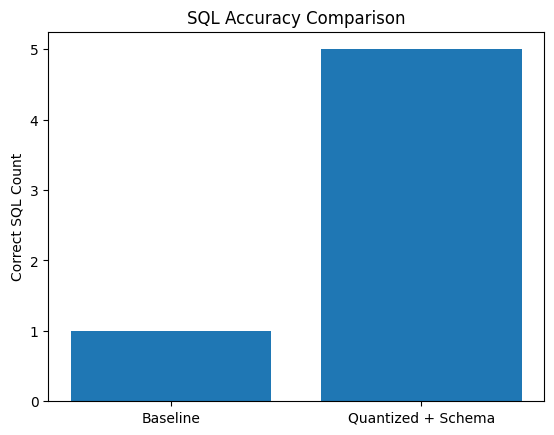

In [49]:
import matplotlib.pyplot as plt

baseline_score = sum(x["baseline_correct"] for x in comparison)
quant_score = sum(x["quantized_schema_correct"] for x in comparison)

plt.bar(
    ["Baseline", "Quantized + Schema"],
    [baseline_score, quant_score]
)
plt.ylabel("Correct SQL Count")
plt.title("SQL Accuracy Comparison")
plt.show()